In [14]:
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit.circuit.library import PauliFeatureMap
from qiskit.primitives import Sampler
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import functools as ft
import numpy as np

In [44]:
N_TRAIN = 100
dim = 3
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=N_TRAIN,
    test_size=int(N_TRAIN/5),
    n=dim,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

In [50]:
def self_product(x: np.ndarray) -> float:
  # R^n (x) -> R (float)
  if len(x) == 1:
    return x[0]

  # coeff = ft.reduce(lambda m, n: m * n, np.pi - x)
  # coeff = ft.reduce(lambda m, n: m + n, np.log(x))
  return np.cos(x[0]) + np.sin(x[1])

feature_map = PauliFeatureMap(
  reps=2,
  paulis=["Z", "ZZ"],
  feature_dimension=5,
  entanglement="linear",
  data_map_func=self_product,
)

adhoc_kernel = FidelityQuantumKernel(
  fidelity=ComputeUncompute(sampler=Sampler()),
  feature_map=feature_map,
)

print(feature_map.draw())

     ┌────────────────────────────────────────────┐
q_0: ┤0                                           ├
     │                                            │
q_1: ┤1                                           ├
     │                                            │
q_2: ┤2 PauliFeatureMap(x[0],x[1],x[2],x[3],x[4]) ├
     │                                            │
q_3: ┤3                                           ├
     │                                            │
q_4: ┤4                                           ├
     └────────────────────────────────────────────┘


In [51]:
adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)

adhoc_svc.fit(train_features, train_labels)

adhoc_score_callable_function = adhoc_svc.score(test_features, test_labels)

print(f"Callable kernel classification test score: {adhoc_score_callable_function}")

Callable kernel classification test score: 0.475


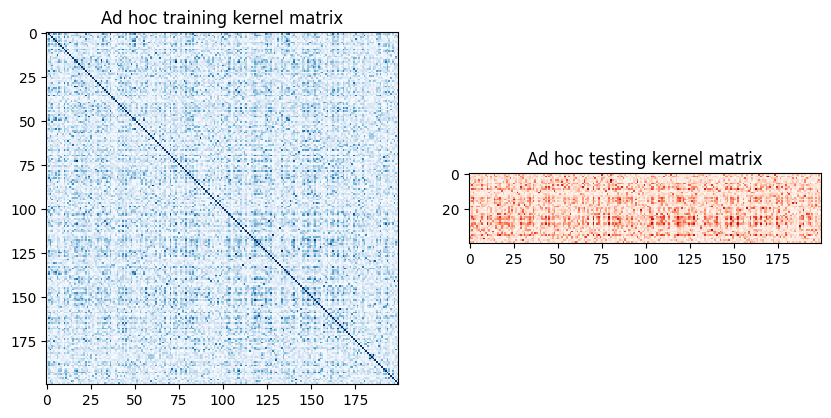

In [52]:
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(adhoc_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")

axs[1].imshow(np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")

plt.show()

In [53]:
print(f"SVC function | {adhoc_score_callable_function:10.2f}")

SVC function |       0.47
